## Jupyter Notebook: Exploring GEO API

This notebook will guide you through retrieving and analyzing GEO datasets using the GEO API.

In [1]:
# Install dependencies (Run this cell first)
!pip install GEOparse pandas matplotlib seaborn

In [1]:
# Import necessary libraries
import os
import time
import requests
import GEOparse
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from IPython.display import display

## Step 1: Retrieve a GEO Dataset (GSE Accession Number)

In [2]:
def fetch_gse_data(accession_id):
    """Fetches GEO Series data for a given accession ID."""
    print(f"Fetching {accession_id} from GEO...")
    gse = GEOparse.get_GEO(geo=accession_id, destdir="./GEO/")
    print(f"Fetched {accession_id} Successfully!")
    return gse

# Example usage: Fetch GSE285812
gse = fetch_gse_data("GSE285812")

01-Mar-2025 16:12:06 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE285nnn/GSE285812/soft/GSE285812_family.soft.gz to ./GEO/GSE285812_family.soft.gz


Fetching GSE285812 from GEO...


01-Mar-2025 16:12:36 ERROR downloader - Error when quiting FTP server.
Traceback (most recent call last):
  File "/Users/egg/micromamba/envs/bio/lib/python3.12/site-packages/GEOparse/downloader.py", line 148, in _download_ftp
    ftp = FTP(parsed_url.netloc)
          ^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/egg/micromamba/envs/bio/lib/python3.12/ftplib.py", line 121, in __init__
    self.connect(host)
  File "/Users/egg/micromamba/envs/bio/lib/python3.12/ftplib.py", line 158, in connect
    self.sock = socket.create_connection((self.host, self.port), self.timeout,
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/egg/micromamba/envs/bio/lib/python3.12/socket.py", line 841, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/egg/micromamba/envs/bio/lib/python3.12/socket.py", line 978, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family

OSError: Download failed due to '[Errno 2] No such file or directory: '/var/folders/xp/g59rxjvd2jbgkq0203smhgm40000gn/T/tmpjcqwat7d''. ID could be incorrect or the data might not be public yet.

## Step 2: Extract Metadata

In [14]:
print("Dataset Title:", gse.metadata["title"])
print("Dataset Summary:", gse.metadata["summary"])
print("Dataset Overall Design:", gse.metadata["overall_design"])
for item in gse.gsms:
    print(item)

Dataset Title: ['Droplet-based high-throughput 3D genome structure mapping of single cells with simultaneous transcriptomics']
Dataset Summary: ['This SuperSeries is composed of the SubSeries listed below.']
Dataset Overall Design: ['Refer to individual Series']
GSM8698727
GSM8698728
GSM8698729
GSM8698730
GSM8698731
GSM8698732
GSM8698919
GSM8698920
GSM8698921
GSM8698922
GSM8698923
GSM8698924
GSM8698925
GSM8709603
GSM8709626


## Step 3: Extract Sample Information

In [30]:
samples = gse.gsms
print(f"Total Samples: {len(samples)}")
print(gse.metadata["title"])
def extract_sample_metadata(gse):
    """Extracts sample metadata from a GEO dataset."""
    metadata = []
    for sample_id, sample in gse.gsms.items():
        metadata.append({
            "Sample ID": sample_id,
            "Title": sample.metadata.get("title", [None])[0],
            "Source Name": sample.metadata.get("source_name_ch1", [None])[0],
            "Organism": sample.metadata.get("organism_ch1", [None])[0],
            "Molecule": sample.metadata.get("molecule_ch1", [None])[0],
            "Description": sample.metadata.get("description", [None])[0]
        })
    return pd.DataFrame(metadata)

print(gse.gsms["GSM8698727"].metadata.get("title"))
print(gse.gsms["GSM8698727"].metadata.get("title", [None])[0])

pd.set_option('display.max_colwidth', None)
sample_df = extract_sample_metadata(gse)
display(sample_df)

Total Samples: 15
['Droplet-based high-throughput 3D genome structure mapping of single cells with simultaneous transcriptomics']
['GM12878 and mESC cell mixture, dscHi-C, cultured']
GM12878 and mESC cell mixture, dscHi-C, cultured


,Sample ID,Title,Source Name,Organism,Molecule,Description
0,GSM8698727,"GM12878 and mESC cell mixture, dscHi-C, cultured","B lymphoblastoid, mouse embryonic stem cell",Homo sapiens,genomic DNA,Library name: mESC-GM_dscHi-C
1,GSM8698728,"mESC, dscHi-C, cultured, rep1",mouse embryonic stem cell,Mus musculus,genomic DNA,Library name: mESC_dscHi-C_1
2,GSM8698729,"mESC, dscHi-C, cultured, rep2",mouse embryonic stem cell,Mus musculus,genomic DNA,Library name: mESC_dscHi-C_2
3,GSM8698730,"mESC, dscHi-C, cultured, subsample",mouse embryonic stem cell,Mus musculus,genomic DNA,Library name: mESC_dscHi-C_sub
4,GSM8698731,"Human cell line mixture, dscHi-C, cultured",mixture,Homo sapiens,genomic DNA,Library name: Cell-line_dscHi-C
5,GSM8698732,"GM12878_dscHi-C, dscHi-C, cultured",B lymphoblastoid,Homo sapiens,genomic DNA,Library name: GM12878_dscHi-C
6,GSM8698919,"Mouse brain cortex, dscHi-C, 12 month-old",Brain cortex,Mus musculus,genomic DNA,Library name: b12-month-BC-dscHiC
7,GSM8698920,"mESC, dscHi-C-multiome, cultured, biotin enrichment, second RT,HiC",mouse embryonic stem cell,Mus musculus,other,Library name: mESC_dscHi-C_multiome_biotin
8,GSM8698921,"mESC, dscHi-C-multiome, cultured, biotin enrichment, second RT, RNA",mouse embryonic stem cell,Mus musculus,other,Library name: mESC_dscHi-C_Multiome_biotin_second_RT_RNA
9,GSM8698922,"mESC, dscHi-C-multiome, cultured, no biotin enrichment, HiC",mouse embryonic stem cell,Mus musculus,other,Library name: mESC_dscHi-C_multiome_no_biotin


## Step 4: Visualization - Sample Distribution

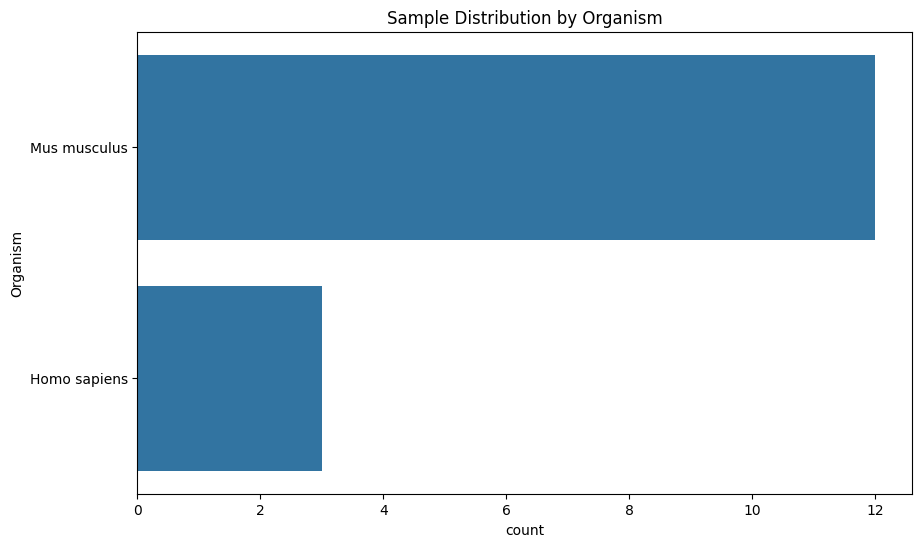

In [31]:
plt.figure(figsize=(10, 6))
sns.countplot(y=sample_df["Organism"], order=sample_df["Organism"].value_counts().index)
plt.title("Sample Distribution by Organism")
plt.show()

## Step 5: Save Extracted Data

In [18]:
sample_df.to_csv("GSE285812_sample_metadata.csv", index=False)

## Step 6: Extract SRX from GEO Metadata

In [19]:
# Function to extract SRX from the GEO metadata
def extract_srx_from_gse(gse):
    """
    Extract SRX (Experiment IDs) from GSM metadata.
    Returns a dictionary mapping GSM IDs to their corresponding SRX.
    """
    srx_mapping = {}

    for gsm_id, gsm in gse.gsms.items():
        relations = gsm.metadata.get("relation", [])
        for relation in relations:
            if "SRA:" in relation:
                srx_id = relation.split("SRA:")[-1].strip()
                if "https://www.ncbi.nlm.nih.gov/sra?term=" in srx_id:
                    srx_id = srx_id.split("term=")[-1]
                srx_mapping[gsm_id] = srx_id
    return srx_mapping

## Step 7: Extract SRR from SRX

In [20]:
# Function to fetch SRR runs from an SRX experiment
def fetch_srr_from_srx(srx_id):
    """
    Queries SRA for SRR (Run IDs) using the SRX Experiment ID.
    """
    url = f"https://www.ncbi.nlm.nih.gov/sra/?term={srx_id}"
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to fetch {srx_id}")
        return []

    soup = BeautifulSoup(response.text, "html.parser")
    srr_list = []
    
    # Search for SRR links
    for link in soup.find_all("a"):
        if "SRR" in link.text:
            srr_list.append(link.text.strip())

    return srr_list

## Step 8: Loading GEO Dataset of Interest

In [21]:
# Load the GEO dataset (Change the accession number as needed)
geo_id = "GSE285812"
gse = GEOparse.get_GEO(geo=geo_id, destdir="./GEO/")

28-Feb-2025 15:02:46 DEBUG utils - Directory ./GEO/ already exists. Skipping.
28-Feb-2025 15:02:46 INFO GEOparse - File already exist: using local version.
28-Feb-2025 15:02:46 INFO GEOparse - Parsing ./GEO/GSE285812_family.soft.gz: 
28-Feb-2025 15:02:46 DEBUG GEOparse - DATABASE: GeoMiame
28-Feb-2025 15:02:46 DEBUG GEOparse - SERIES: GSE285812
28-Feb-2025 15:02:46 DEBUG GEOparse - PLATFORM: GPL24247
28-Feb-2025 15:02:46 DEBUG GEOparse - PLATFORM: GPL24676
28-Feb-2025 15:02:46 DEBUG GEOparse - SAMPLE: GSM8698727
28-Feb-2025 15:02:46 DEBUG GEOparse - SAMPLE: GSM8698728
28-Feb-2025 15:02:46 DEBUG GEOparse - SAMPLE: GSM8698729
28-Feb-2025 15:02:46 DEBUG GEOparse - SAMPLE: GSM8698730
28-Feb-2025 15:02:46 DEBUG GEOparse - SAMPLE: GSM8698731
28-Feb-2025 15:02:46 DEBUG GEOparse - SAMPLE: GSM8698732
28-Feb-2025 15:02:46 DEBUG GEOparse - SAMPLE: GSM8698919
28-Feb-2025 15:02:46 DEBUG GEOparse - SAMPLE: GSM8698920
28-Feb-2025 15:02:46 DEBUG GEOparse - SAMPLE: GSM8698921
28-Feb-2025 15:02:46 DEBUG

## Step 9: Perform Querries

In [22]:
# Step 1: Extract GSM -> SRX mapping
gsm_to_srx = extract_srx_from_gse(gse)

# Step 2: Query SRA to get SRR IDs
geo_sra_data = []
for gsm, srx in gsm_to_srx.items():
    print(f"Fetching SRR for {gsm} -> {srx}...")
    srr_ids = fetch_srr_from_srx(srx)
    time.sleep(2)  # Avoid rate limits
    geo_sra_data.append({
        "GSM_ID": gsm,
        "SRX_ID": srx,
        "SRR_IDs": ", ".join(srr_ids) if srr_ids else "No SRRs found"
    })

Fetching SRR for GSM8698727 -> SRX27171371...
Fetching SRR for GSM8698728 -> SRX27171372...
Fetching SRR for GSM8698729 -> SRX27171373...
Fetching SRR for GSM8698730 -> SRX27171374...
Fetching SRR for GSM8698731 -> SRX27171375...
Fetching SRR for GSM8698732 -> SRX27171376...
Fetching SRR for GSM8698919 -> SRX27175014...
Fetching SRR for GSM8698920 -> SRX27175667...
Fetching SRR for GSM8698921 -> SRX27175668...
Fetching SRR for GSM8698922 -> SRX27175669...
Fetching SRR for GSM8698923 -> SRX27175670...
Fetching SRR for GSM8698924 -> SRX27175671...
Fetching SRR for GSM8698925 -> SRX27175672...
Fetching SRR for GSM8709603 -> SRX27243324...
Fetching SRR for GSM8709626 -> SRX27243557...


## Step 10: Save Data

In [27]:
# Convert to DataFrame
geo_sra_df = pd.DataFrame(geo_sra_data)

# Display the structured DataFrame
display(name="GEO SRA Data", dataframe=geo_sra_df)

# Save to CSV
output_csv_name = os.path.join("./GEO/", f"{geo_id}_sra_metadata.csv")
geo_sra_df.to_csv(output_csv_name, index=False)

## Huge Class Test

In [5]:
# Import GeoDataDownloader from here

import sys
from pathlib import Path

# Define the base path of your project
project_root = Path().resolve().parent  # Moves one level up from /notebooks/

print(project_root)
# Add project root to sys.path
sys.path.append(str(project_root))

# Now you can import the module
from data.geo_sra_downloader import GEODataDownloader

/Users/egg/Projects/Bloom


In [6]:
# Test if it works
gse_id = "GSE285812"
path_location = "/Users/egg/Projects/Bloom/data/raw"
geo = GEODataDownloader(gse_id, path_location)
print(geo)
geo.create_metadata_table()

01-Mar-2025 16:10:36 DEBUG utils - Directory /Users/egg/Projects/Bloom/data/raw/GSE285812_temp already exists. Skipping.
01-Mar-2025 16:10:36 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE285nnn/GSE285812/soft/GSE285812_family.soft.gz to /Users/egg/Projects/Bloom/data/raw/GSE285812_temp/GSE285812_family.soft.gz


Fetching GEO dataset: GSE285812


01-Mar-2025 16:11:06 ERROR downloader - Error when quiting FTP server.
Traceback (most recent call last):
  File "/Users/egg/micromamba/envs/bio/lib/python3.12/site-packages/GEOparse/downloader.py", line 148, in _download_ftp
    ftp = FTP(parsed_url.netloc)
          ^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/egg/micromamba/envs/bio/lib/python3.12/ftplib.py", line 121, in __init__
    self.connect(host)
  File "/Users/egg/micromamba/envs/bio/lib/python3.12/ftplib.py", line 158, in connect
    self.sock = socket.create_connection((self.host, self.port), self.timeout,
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/egg/micromamba/envs/bio/lib/python3.12/socket.py", line 841, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/egg/micromamba/envs/bio/lib/python3.12/socket.py", line 978, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family

RuntimeError: Failed to fetch GEO dataset GSE285812: Download failed due to '[Errno 2] No such file or directory: '/var/folders/xp/g59rxjvd2jbgkq0203smhgm40000gn/T/tmpbb2v5i9x''. ID could be incorrect or the data might not be public yet.

In [5]:
import os
import multiprocessing

# Number of logical cores
print("Logical CPUs:", os.cpu_count())

# Number of physical cores (for some systems)
print("Physical CPUs:", multiprocessing.cpu_count())

Logical CPUs: 10
Physical CPUs: 10


In [ ]:
# geo.download_raw_data(num_workers = 5)